# **ISIC 2016 Challenge - Lesion Segmentation**

# **Imports and variable declarations**

In [1]:
import os # os functionalities
import random # generation of random numbers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
from matplotlib import pyplot as plt # image visualization

# Tensorflow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

# Image manipulation
from skimage import io
from PIL import Image, ImageOps
from IPython.display import Image, display

In [2]:
# Variable declaration
input_dir = "../input/isic-2016-challenge-lesion-segmentation/ISBI2016_ISIC_Part1_Training_Data/ISBI2016_ISIC_Part1_Training_Data"
target_dir = "../input/isic-2016-challenge-lesion-segmentation/ISBI2016_ISIC_Part1_Training_GroundTruth/ISBI2016_ISIC_Part1_Training_GroundTruth"

img_size = (160, 160)
batch_size = 8
num_classes = 2 # 0 - 1 / lesion - no lesion

# Percentages of images going to train - val - test sets
percentage_test = 0.05
percentage_validation = 0.2

# **Data loading**

In [3]:
# Get paths to the training and target images
input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

# Check if dimentions are equal
print("Number of samples in the training set:", len(input_img_paths))
print("Number of samples in the target set:", len(target_img_paths))

Number of samples in the training set: 900
Number of samples in the target set: 900


# **Data visualization**

The shape of the pictures in the training set is: (768, 1024, 3)
The shape of the pictures in the target set is: (768, 1024)


Text(0.5, 1.0, 'Segmentation mask')

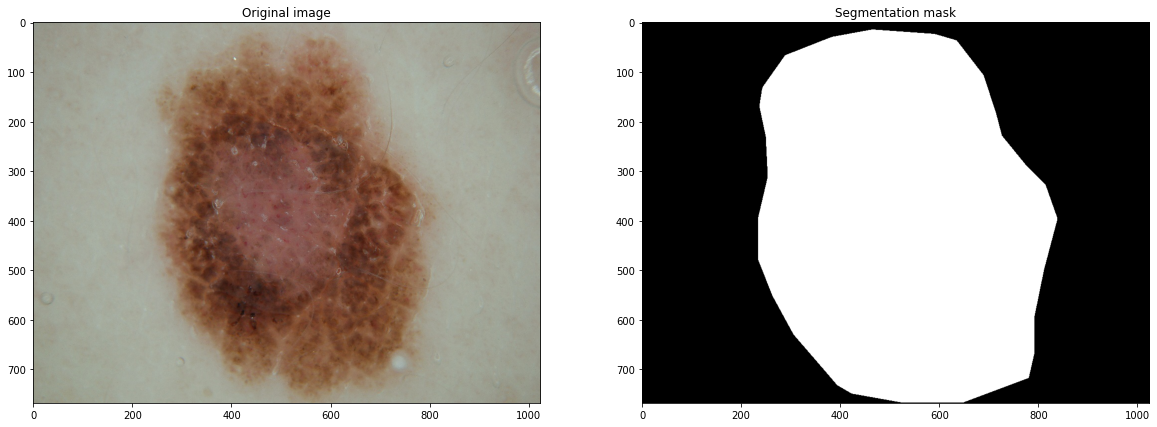

In [4]:
# Read training images and get their shape
image_to_visualize = 500
img1 = io.imread(input_img_paths[image_to_visualize])
img_shape = np.shape(img1)
print(f"The shape of the pictures in the training set is: {img_shape}")

# Read target images and get their shape
img1 = io.imread(target_img_paths[image_to_visualize])
img_shape = np.shape(img1)
print(f"The shape of the pictures in the target set is: {img_shape}")


# Create figure
fig = plt.figure(figsize=(20, 20))

# Cetting values to rows and column variables
rows = 1
columns = 2

# Plot images - Visualize an image and it's segmentation
fig.add_subplot(rows, columns, 1)
plt.imshow(io.imread(input_img_paths[image_to_visualize]))
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(io.imread(target_img_paths[image_to_visualize]), cmap='gray')
plt.title("Segmentation mask")

# **Load and vectorize batches of data**

Sequence structure guarantees that the network will only train once on each sample per epoch which is not the case with generators. Thus, is a safer way to do multiprocessing.

In [5]:
class LesionSegmentation(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = tf.cast(img, tf.float32)/255.0
            
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = (np.expand_dims(img, 2)/255).astype(int)
            
        return x, y

In [6]:
# Split our img paths into a training validation and test sets
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

test_samples = int(len(input_img_paths)*percentage_test)
train_input_img_paths = input_img_paths[:-test_samples]
train_target_img_paths = target_img_paths[:-test_samples]
test_input_img_paths = input_img_paths[-test_samples:]
test_target_img_paths = target_img_paths[-test_samples:]

val_samples = int(len(train_input_img_paths)*percentage_validation)
val_input_img_paths = train_input_img_paths[-val_samples:]
val_target_img_paths = train_target_img_paths[-val_samples:]
train_input_img_paths = train_input_img_paths[:-val_samples]
train_target_img_paths = train_target_img_paths[:-val_samples]

print(f"Samples in train: {len(train_input_img_paths)}")
print(f"Samples in validation: {len(val_input_img_paths)}")
print(f"Samples in test: {len(test_input_img_paths)}")

Samples in train: 684
Samples in validation: 171
Samples in test: 45


In [7]:
# Instantiate data Sequences for each split
train_gen = LesionSegmentation(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = LesionSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths)

# **Model definition**

In [8]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

2022-10-10 12:43:03.885632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 12:43:03.979505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 12:43:03.980274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 12:43:03.981321: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# **Model training**

In [9]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# binary_crossentropy funciona nice (0.16)

callbacks = [keras.callbacks.ModelCheckpoint("lesion_segmentaion.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 10
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

2022-10-10 12:43:07.411083: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-10-10 12:43:12.097791: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


85/85 [==============================] - 70s 706ms/step - loss: 0.8719 - val_loss: 1.0966


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
85/85 [==============================] - 45s 536ms/step - loss: 0.2986 - val_loss: 0.7544
Epoch 3/10
85/85 [==============================] - 45s 536ms/step - loss: 0.2377 - val_loss: 0.8006
Epoch 4/10
85/85 [==============================] - 45s 528ms/step - loss: 0.2069 - val_loss: 1.2149
Epoch 5/10
85/85 [==============================] - 45s 534ms/step - loss: 0.1745 - val_loss: 0.5811
Epoch 6/10
85/85 [==============================] - 45s 532ms/step - loss: 0.1603 - val_loss: 0.2349
Epoch 7/10
85/85 [==============================] - 45s 527ms/step - loss: 0.1496 - val_loss: 0.2173
Epoch 8/10
85/85 [==============================] - 45s 527ms/step - loss: 0.1324 - val_loss: 0.2246
Epoch 9/10
85/85 [==============================] - 45s 536ms/step - loss: 0.1295 - val_loss: 0.2761
Epoch 10/10
85/85 [==============================] - 45s 520ms/step - loss: 0.1211 - val_loss: 0.2042


# **Model evaluation**

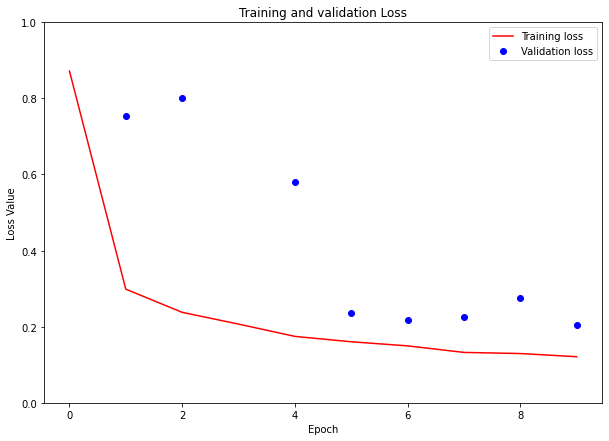

In [10]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(10, 7))
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig('Training and validation loss.jpg', dpi=500)
plt.show()

In [11]:
test_gen = LesionSegmentation(batch_size, img_size, test_input_img_paths, test_target_img_paths)
test_preds = model.predict(test_gen)

jaccard_scores = []
test = []

for i in range(0, len(test_preds)):
    # Adapt prediction
    prediction = np.argmax(test_preds[i], axis=-1)
    prediction = np.expand_dims(prediction, axis=-1)
    ground_truth = np.array(load_img(test_target_img_paths[i], target_size=img_size, color_mode="grayscale"))
    
    # Get Jaccard score
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)
    jaccard_scores.append(np.sum(intersection) / np.sum(union))    

# **Model predictions**

In [12]:
# Generate predictions for all images in the validation set
def adapt_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img

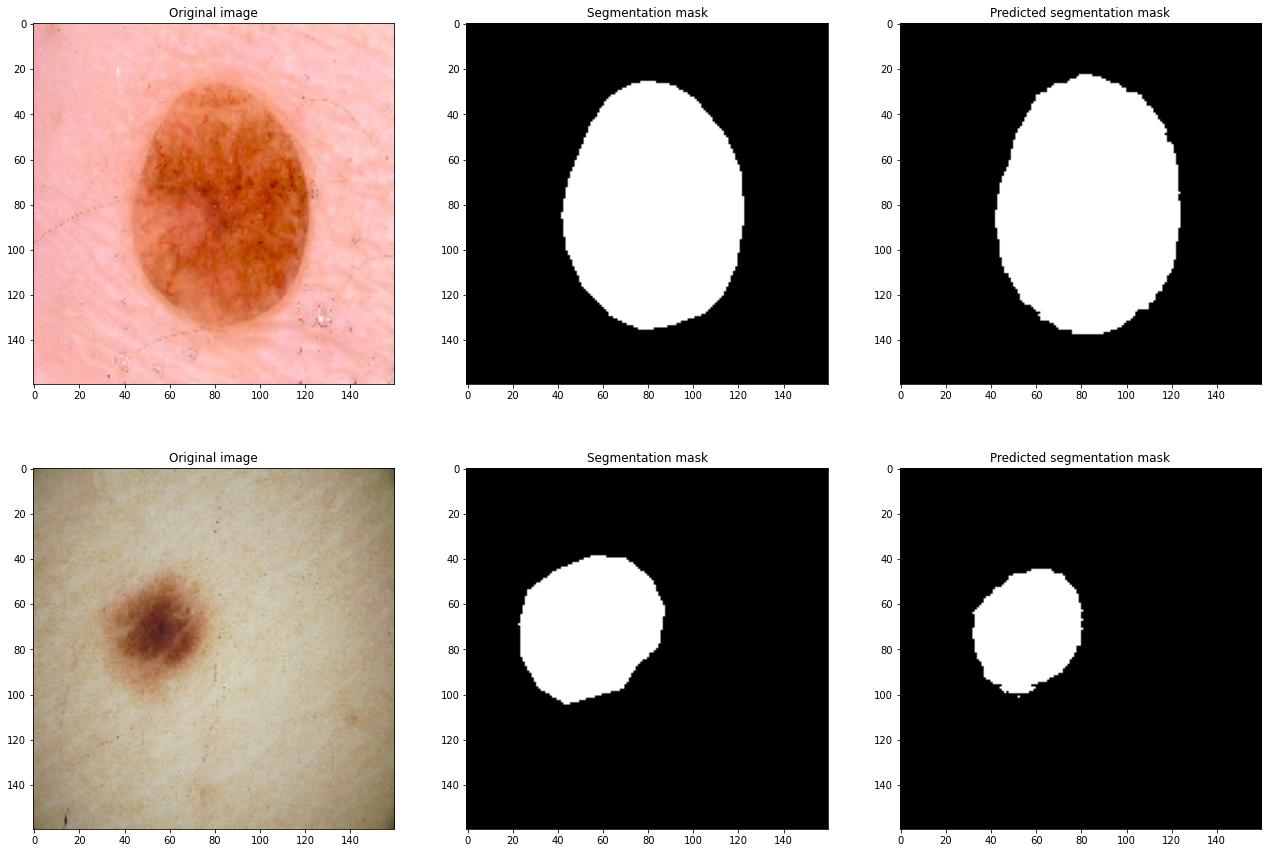

In [13]:
# Cetting values to rows and column variables
rows = 2
columns = 3

# Create figure
fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(22, 15))
row = 0

for i in [1, 4]:
    
    column = 0
    
    # Plot images
    axs[row, column].imshow(load_img(test_input_img_paths[i], target_size=img_size))
    axs[row, column].set_title("Original image")
    column+=1
    
    axs[row, column].imshow(load_img(test_target_img_paths[i],  target_size=img_size), cmap='gray')
    axs[row, column].set_title("Segmentation mask")
    column+=1
    
    axs[row, column].imshow(adapt_mask(i), cmap='gray')
    axs[row, column].set_title("Predicted segmentation mask")
    column+=1
    row+=1

plt.savefig('Predicted segmantation masks.jpg', dpi=300)